In [8]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import json
import math
import pathlib
from typing import Dict, Optional, Sequence

from peft import get_peft_config, get_peft_model, PromptTuningInit, PromptTuningConfig, TaskType, PeftType, AutoPeftModel, AutoPeftModelForCausalLM
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
import transformers
from transformers import Trainer, BitsAndBytesConfig
from transformers.trainer_pt_utils import LabelSmoother
from transformers import LlamaForCausalLM
from prompt.model.modeling_llama_custom import LlamaForCausalLM as CustomLlamaForCausalLM

from fastchat.conversation import SeparatorStyle
from fastchat.model.model_adapter import get_conversation_template
from torch.nn import CrossEntropyLoss
from torch.nn import functional as F

from contextlib import contextmanager
from prompt.utils import *
from prompt.model.model import PromptDecoder, AutoPromptDecoder, PromptConfig
from prompt.model.kv_cache import *

from pprint import pprint
from prompt.inference.dynamic_sparse_trees_3_vicuna_7b import *
 
candidate_lists = dynamic_sparse_trees_60

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
import time

@contextmanager
def timed(wall_times, key):
    torch.cuda.synchronize()
    start = time.time()
    yield
    torch.cuda.synchronize()
    end = time.time()
    elapsed_time = end - start
    wall_times[key].append(elapsed_time)

# Prompt Decoding

In [ ]:
model = AutoPromptDecoder.from_pretrained(
    "hmarkc/ppd-vicuna-7b-v1.3",
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
)
model.to(device)
print(type(model))
print(model.print_trainable_parameters())

In [11]:
wall_times = {'init': [], 'candidates': [], 'forward_pass': [], 'evaluation': [], 'update': []}
prompt = "A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Hi, could you share a tale about a big brain that is good at multi-tasking and likes prompt engineering? ASSISTANT:"
input_ids = model.tokenizer(prompt, return_tensors="pt").input_ids.to(device)
with torch.inference_mode():
  if not hasattr(model, "inference_buffers"):
    print("Generating buffers")
    model.generate_dynamic_buffers(candidate_lists)
  (past_key_values,
      past_key_values_data,
      current_length_data,
  ) = initialize_past_key_values(model.base_model)
  with timed(wall_times, 'init'):
    logits, prompt_logits = model.start_inference(input_ids, past_key_values, current_length_data)
new_token = 0
accept_lengths = []
print(model.tokenizer.batch_decode(logits.argmax(-1)))

Generating buffers
['Once']


In [12]:
temperature = 0.0
posterior_threshold = 0.09
posterior_alpha = 0.3
sampling = 'greedy'

In [13]:
kv_cache_lengths = []
latencies = []
for _ in range(512):
  with torch.inference_mode():
    with timed(wall_times, 'candidates'):
      candidates, tree_candidates_embeds = model.generate_candidates(
        logits, 
        prompt_logits, 
        temperature, 
        posterior_threshold, 
        posterior_alpha, 
        sampling)
    kv_cache_lengths.append(past_key_values[0][0].shape[2])
    with timed(wall_times, 'forward_pass'):
      logits, all_logits = model.tree_decoding(tree_candidates_embeds, past_key_values, input_ids)
    latencies.append(wall_times['forward_pass'][-1])
    with timed(wall_times, 'evaluation'):
      best_candidate, accept_length = model.evaluate_posterior(
        logits, 
        candidates, 
        temperature, 
        posterior_threshold, 
        posterior_alpha,
        sampling)
    accept_lengths.append(accept_length.cpu().item()+1)
    with timed(wall_times, 'update'):
            input_ids, logits, prompt_logits, new_token = model.update_inference_inputs(
                    input_ids,
                    candidates,
                    best_candidate,
                    accept_length,
                    logits,
                    all_logits,
                    new_token,
                    past_key_values_data,
                    current_length_data,
            )
    torch.cuda.empty_cache()
    if model.tokenizer.eos_token_id in input_ids[0, :].tolist():
      break
print(model.tokenizer.decode(input_ids[0], spaces_between_special_tokens=False,))

<s> A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Hi, could you share a tale about a big brain that is good at multi-tasking and likes prompt engineering? ASSISTANT: Once upon a time, in a land far, far away, there was a big brain named Brain. Brain was known for being incredibly smart and good at multi-tasking. He could think about multiple things at once and always seemed to be able to find the best solution to any problem.

One of Brain's favorite things to do was prompt engineering. He loved taking prompts and using his big brain to come up with creative and innovative solutions. Whether it was designing a new piece of technology or writing a catchy advertisement, Brain was always up for a challenge.

One day, Brain was approached by a group of people who were struggling to come up with a new product idea. They had tried everything, but nothing seemed to be working. Br

Average 1 forward pass time 0.03628241593110646 s
Token generation speed 55.979489092288745 tokens/s
Average accept length 2.141843971631206
Percentage of time spent on candidates generation 0.018525055938397275 average time 0.0007087913810784089
Percentage of time spent on forward pass 0.9482815432677923 average time 0.03628241593110646
Percentage of time spent on evaluation 0.009917768456798499 average time 0.0003794659959509018
Percentage of time spent on update 0.023275632337011885 average time 0.0008905542657730427


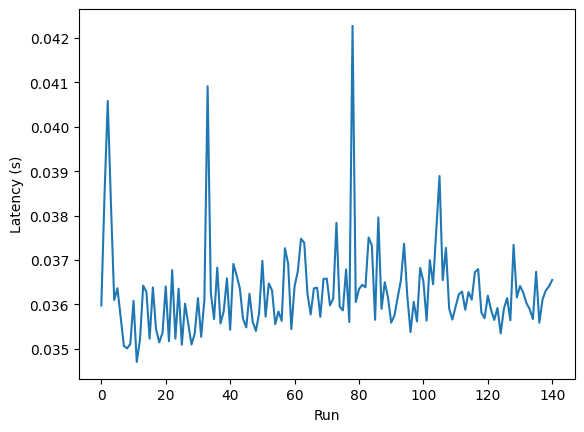

In [14]:
candidate_time = sum(wall_times['candidates'])
forward_time = sum(wall_times['forward_pass'])
evaluation_time = sum(wall_times['evaluation'])
update_time = sum(wall_times['update'])
total_time = candidate_time + forward_time + evaluation_time + update_time

print('Average 1 forward pass time', {k: sum(v)/len(v) for k, v in wall_times.items()}['forward_pass'], 's')
print('Token generation speed', new_token.cpu().item()/total_time, 'tokens/s')
print('Average accept length', sum(accept_lengths)/len(accept_lengths))

# print percentage of time spent on each step
print('Percentage of time spent on candidates generation', candidate_time/total_time, 'average time', candidate_time/len(latencies))
print('Percentage of time spent on forward pass', forward_time/total_time, 'average time', forward_time/len(latencies))
print('Percentage of time spent on evaluation', evaluation_time/total_time, 'average time', evaluation_time/len(latencies))
print('Percentage of time spent on update', update_time/total_time, 'average time', update_time/len(latencies))

# plot latencies against runs
import matplotlib.pyplot as plt
plt.plot(latencies)
plt.xlabel('Run')
plt.ylabel('Latency (s)')
plt.show()